In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from scipy import signal
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Global setpoints 
columns_input = ['line_2_inp_flow','line_2_out_flow','power']
columns_analyze = ['line_2_inp_flow','power','target_delta_flow']
columns_fit = ['line_2_inp_flow','power'] 
target_name = 'target_delta_flow' #name for model target

csv_separator = ';' #'\t'

N_MEAN_ROLLING = 2 #Apply mean rolling for all set
N_SELECT = 2 #Take only each N-s entry for analyse
N_PREV = 5 #Time back window size
N_MIN_SUBGROUP = 13 #Limit sub groups minimum size. Used for butter filter. E.g. butter filter requires minimum 13 elements.
PLNM = False #Aply polynomial or not
MERGE = False #Merge sub datas together
PCA_EN = False #Apply PCA or not

In [3]:
#Pipeline global parameters
pca = PCA(0.99, random_state = RANDOM_STATE)
scaler = StandardScaler()
polynom = PolynomialFeatures(degree=2)

In [4]:
###########################
#Project specific funtions
###########################

#Preprocessing
def preprocess_data_df(inp_df):  #Preprocess as pandas df
    """
    Custom preprocessing of data frame
    """
    inp_df['target_delta_flow'] = inp_df['line_2_out_flow'] - inp_df['line_2_inp_flow']
    #inp_df['power_filtered'] = inp_df['power']
    #inp_df['target_delta_nofilter'] = inp_df['target_delta_flow']
    

#Filtering
b, a = signal.butter(3, 0.1)

columns_filtered = ['line_2_inp_flow','power','target_delta_flow']

def filtering(inp_data, columns=None):
    if columns:
        return np.transpose([signal.filtfilt(b, a, inp_data[:,i]) if i in columns_filtered_index else inp_data[:,i] for i in range(inp_data.shape[1])])
    else:
        return signal.filtfilt(b, a, inp_data, axis=0)

In [5]:
###########################
#Base functions
###########################

#Help functions
def get_indexes(inp_main, inp_search):
    return [inp_main.index(i) for i in inp_search]

def get_index(inp_main, inp_search):
    return inp_main.index(inp_search)

#Get column index by name
columns_filtered_index = get_indexes(columns_analyze, columns_filtered)
columns_fit_index = get_indexes(columns_analyze,columns_fit)
target_index = get_index(columns_analyze,target_name)

#Rolling mean function. Reduce data by N_MEAN_ROLLING-1
def rolling_mean_along_axis(inp):
    return np.convolve(inp, np.ones(N_MEAN_ROLLING), 'valid') / N_MEAN_ROLLING    
    
def rolling_mean(inp):
    return np.apply_along_axis(rolling_mean_along_axis, 0, inp)

#Fit/transform scaler, polynom, pca
def pca_scaler_data(inp_data,fit_en,pca_en,plnm):  
    
    if inp_data.size !=0:
        if fit_en:
            out_data  = scaler.fit_transform(inp_data)
            if plnm:
                out_data = polynom.fit_transform(out_data)
            if pca_en:
                out_data = pca.fit_transform(out_data)
        else:
            out_data  = scaler.transform(inp_data)
            if plnm:
                out_data  = polynom.transform(out_data)
            if pca_en:
                out_data = pca.transform(out_data)   
    else:
        out_data = inp_data
    return out_data 

def data_sliding_window(inp_X,inp_y, n_prev):  
    buffer_X, buffer_Y = [], []
    for i in range(len(inp_X)-n_prev+1):
        buffer_X.append(inp_X[i:i+n_prev])
        buffer_Y.append(np.array(inp_y)[i+n_prev-1])
    result_X = np.array(buffer_X)
    result_Y = np.array(buffer_Y)
    return result_X, result_Y 

def data_x_scale_and_split(inp_data_unscaled, test_size, fit_en):
    #Get amount of training data
    num_training = round(len(inp_data_unscaled) * (1 - test_size))

    #Fit scaler and pca by train data and use transform for test
    X_train_unscaled = inp_data_unscaled[0:num_training] 
    X_test_unscaled  = inp_data_unscaled[num_training:] 
    X_train_scaled = pca_scaler_data(X_train_unscaled, fit_en, PCA_EN, PLNM)
    X_test_scaled  = pca_scaler_data(X_test_unscaled, False, PCA_EN, PLNM)
    
    #Combine back together scaled and pca data
    if len(X_train_scaled) == 0:
        X_full = X_test_scaled
    elif len(X_test_scaled) == 0:
        X_full = X_train_scaled
    else:
        X_full = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
    
    return X_full, num_training

#Plot merged data np
def plot_data(inp_np, ll=0, ul=1, plot_together=True):
    ll = round(len(inp_np) * ll) 
    ul = round(len(inp_np) * ul) 
    if plot_together:
        with plt.style.context('bmh'):    
            plt.figure(figsize=(15, 8))
            plt.plot(inp_np[ll:ul,:]);
            plt.legend([columns_analyze[k] for k in range(inp_np.shape[1])])
    else:
        for k in range(inp_np.shape[1]):
            with plt.style.context('bmh'):    
                plt.figure(figsize=(15, 8))
                col_name = columns_analyze[k]
                plt.title("Measuring %s"%col_name)
                plt.plot(inp_np[ll:ul,k]);
                
def plot_predicted(X_inp, y_inp, model, range_low = 0, range_high=1, range_up=None, range_down=None, extra_plot_list=None):  
    num_elem = X_inp.shape[1]*X_inp.shape[2]
    predicted = model.predict(X_inp.reshape(-1,num_elem))
    n_hi  = round(len(X_inp) * range_high)
    n_low = round(len(X_inp) * range_low)

    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        plt.plot(predicted[n_low:n_hi])
        plt.plot(y_inp[n_low:n_hi])
        plt.ylim([range_down,range_up])
        plt.legend(['%s predicted'%target_name, '%s'%target_name])
        
    if extra_plot_list:
        for k in extra_plot_list:
            with plt.style.context('bmh'):
                plt.figure(figsize=(15, 8))
                plt.title(k) 
                plt.plot(X_inp[:,-1,get_index(columns_analyze,k)])

In [6]:
def generate_data_set(file_list,merge,fit_en=True,test_size=0):

    data_stack = []
    
    print('========================')
    for j in file_list:
        inp_data = pd.read_csv(j, sep=csv_separator, header = 0)
        inp_data.columns = columns_input

        print("Initial lenght of %a data file is %s"%(j,len(inp_data)))

        #Preprocess
        preprocess_data_df(inp_data)

        #Select used columns
        inp_data = inp_data[columns_analyze] 

        #Remove nans rows
        inp_data_has_nan = inp_data.isnull().values.any()
        inp_data.dropna(inplace=True)

        #We don't use windows with gaps for analyse
        #Some trick to find the gaps - where index jumps
        gap_indexes = [len(inp_data)]
        if not merge:
            gap_indexes = np.append(np.where(np.roll(inp_data.index, -1)-inp_data.index>1)[0]+1, gap_indexes)

        #Convert to np.array
        inp_data = np.array(inp_data)

        #Split input file by gaps
        prev_gap_index=0
        for gap_index in gap_indexes:
            sub_len = gap_index-prev_gap_index
            #Limit minimus size of sub data
            min_size = max(N_MEAN_ROLLING,N_SELECT*N_PREV,N_MIN_SUBGROUP)
            if (sub_len>=min_size):
                sub_arr = inp_data[prev_gap_index:gap_index]
                data_stack.append(sub_arr)
            prev_gap_index = gap_index

    #Meged data
    data_merged = np.array([])

    print('Merging is',merge)
        
    #Merging data and process data
    if not merge:
        len_stack = []

        #Processing of sub data
        for idx,n in enumerate(data_stack):
            #Filter data
            res = filtering(n, columns = columns_filtered_index) 
            #Apply mean rolling
            res = rolling_mean(res)
            #Reduce data by selection one of N
            data_stack[idx] = res[0::N_SELECT]
            #Record sub data mapping
            len_stack.append(len(data_stack[idx]))
            print("Length of filtered sub data piece withount merging is %s"%(len(data_stack[idx])))

        #Fit scaler on trainig data and use for transformation of test data
        data_merged = np.concatenate(data_stack, axis=0)

        #Separate X and Y data
        X_full_unscaled = data_merged[:,columns_fit_index]
        y_full = data_merged[:,target_index]

        X_full, num_training = data_x_scale_and_split(X_full_unscaled, test_size, fit_en)

        #Now generate window-like data. Window slides only within the sub data. Also we don't apply sliding window for Test-Train border.
        #It means if we have one sub data both in Train and Test frame we split this sub data by two blocks.
        pointer_beg = 0
        pointer_end = 0
        buffer_X_train = []
        buffer_y_train = []
        buffer_X_test = []
        buffer_y_test = []
        for v in len_stack:
            pointer_end += v
            #Prevent data leakage on Train->Test border
            if (pointer_end>num_training) and (pointer_beg<=num_training):
                if((num_training-pointer_beg)>=N_PREV):
                    X_part,y_part = data_sliding_window(X_full[pointer_beg:num_training],y_full[pointer_beg:num_training],N_PREV)
                    buffer_X_train.append(X_part)
                    buffer_y_train.append(y_part)
                if((pointer_end-num_training)>=N_PREV):
                    X_part,y_part = data_sliding_window(X_full[num_training:pointer_end],y_full[num_training:pointer_end],N_PREV)
                    buffer_X_test.append(X_part)
                    buffer_y_test.append(y_part)
            else:
                X_part,y_part = data_sliding_window(X_full[pointer_beg:pointer_end],y_full[pointer_beg:pointer_end],N_PREV)
                if(pointer_end>num_training):
                    buffer_X_test.append(X_part)
                    buffer_y_test.append(y_part)
                else:
                    buffer_X_train.append(X_part)
                    buffer_y_train.append(y_part)

            pointer_beg += v

        X_train = np.concatenate(buffer_X_train) if buffer_X_train else np.array([])  
        X_test = np.concatenate(buffer_X_test) if buffer_X_test else np.array([]) 
        y_train = np.concatenate(buffer_y_train) if buffer_y_train else np.array([])
        y_test = np.concatenate(buffer_y_test)  if buffer_y_test else np.array([])

    else:
        data_merged = np.concatenate(data_stack, axis=0)
        data_merged = filtering(data_merged, columns=columns_filtered_index) 
        data_merged = rolling_mean(data_merged)
        data_merged = data_merged[0::N_SELECT]
        print("Length of filtered and merged data is %s"%(len(data_merged)))

        #Separate X and Y data
        X_full_unscaled = data_merged[:,columns_fit_index]
        y_full = data_merged[:,target_index]

        X_full, num_training = data_x_scale_and_split(X_full_unscaled, test_size, fit_en)

        X_train, y_train = data_sliding_window(X_full[:num_training],y_full[:num_training],N_PREV)
        X_test, y_test = data_sliding_window(X_full[num_training:],y_full[num_training:],N_PREV)
    
    print('Train/Test split point is %s/%s'%(num_training,len(X_full)-num_training))
    print('TRAIN data shape', X_train.shape)
    print('TEST  data shape', X_test.shape)
        
    return X_train, y_train, X_test, y_test, data_merged



X_train, y_train, X_test, y_test, data_np = generate_data_set(['./data/export_20171026.txt','./data/export_20171027.txt'],merge=True,fit_en=True,test_size=0)
data_np

Initial lenght of './data/export_20171026.txt' data file is 50
Initial lenght of './data/export_20171027.txt' data file is 11
Merging is True
Length of filtered and merged data is 17
Train/Test split point is 17/0
TRAIN data shape (13, 5, 2)
TEST  data shape (0,)


array([[3.13933741e+02, 9.82092473e+01, 2.58548901e+00],
       [3.14015225e+02, 9.59525786e+01, 2.48864985e+00],
       [3.14112228e+02, 9.41180854e+01, 2.35803192e+00],
       [3.14232995e+02, 9.28431676e+01, 2.17394510e+00],
       [3.14384099e+02, 9.20705861e+01, 1.92155033e+00],
       [3.14564272e+02, 9.16396580e+01, 1.60286867e+00],
       [3.14758972e+02, 9.13871490e+01, 1.24636371e+00],
       [3.14943719e+02, 9.12058158e+01, 9.00381296e-01],
       [3.15098252e+02, 9.10457613e+01, 6.06937875e-01],
       [3.15216486e+02, 9.08902284e+01, 3.82057126e-01],
       [3.15300482e+02, 9.07432908e+01, 2.24255228e-01],
       [3.15347144e+02, 9.06329646e+01, 1.37708129e-01],
       [3.15341294e+02, 9.06111264e+01, 1.46843302e-01],
       [3.15261575e+02, 9.07386250e+01, 2.89428894e-01],
       [3.15092185e+02, 9.10639158e+01, 5.96996468e-01],
       [3.14832414e+02, 9.15996015e+01, 1.07520002e+00],
       [3.14503241e+02, 9.23031185e+01, 1.68786030e+00]])

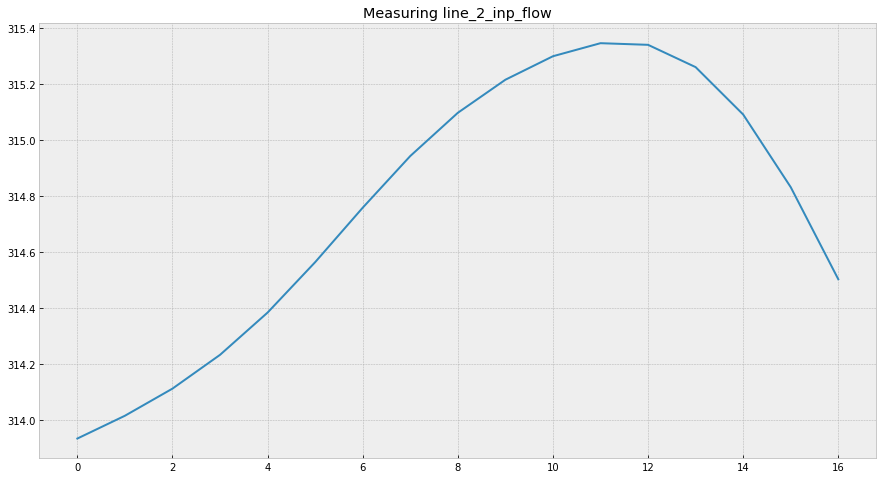

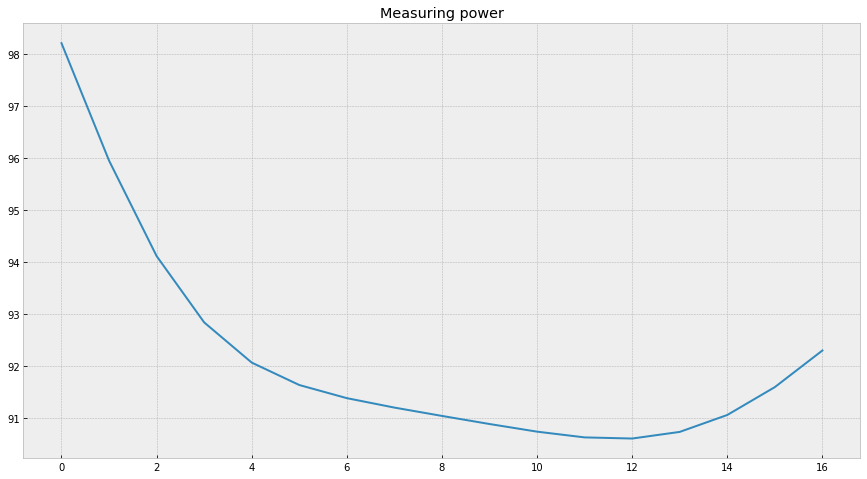

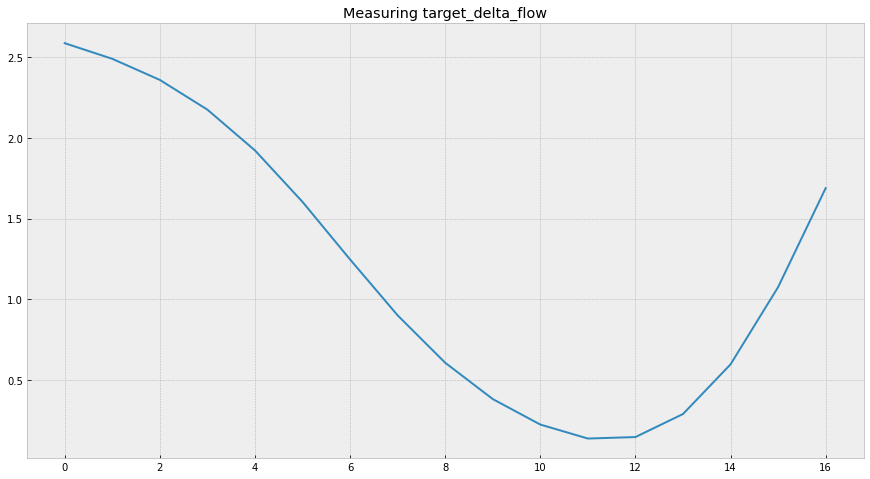

In [7]:
plot_data(data_np, ll=0, ul=1, plot_together=False)            

In [8]:
#################################Linear regresion - ElasticNet/ SVR
#linear = LinearRegression()
#lasso = Lasso()
#ridge = Ridge()
elasticnet = ElasticNet()
#srv = SVR(kernel='rbf',verbose=True) #C=1e3, gamma=0.1


#pca1 = PCA(0.95, random_state = RANDOM_STATE)
#scaler1 = StandardScaler()
#scaler2 = MinMaxScaler(feature_range=(-1, 1))
srv_pipe = Pipeline([   
                        #('pca1',pca1),                    
                        #('scaler1',scaler1),
                        #('scaler2',scaler2),
                        #('poly', PolynomialFeatures(degree=2)),
                        #('linear', linear) 
                        #('lasso', lasso)
                        #('ridge', ridge)
                        ('elasticnet', elasticnet) 
                        #('srv', srv)  
                        ])

srv_pipe_params = {#'srv__C': np.logspace(-0, 6, 4) 
                    #,'srv__gamma': np.logspace(-4, 1, 4) 
                   #,'srv__loss' : ['epsilon_insensitive','squared_epsilon_insensitive']
                    #'srv__kernel: ['rbf', 'linear','poly'] 
                    
                    #'lasso__alpha' : np.logspace(-4, 2, 4) 
                    #'linear__fit_intercept ' : [True,False] 
                    #'ridge__alpha' : np.logspace(0, 4, 4)
                    'elasticnet__alpha' : np.logspace(-4, 1, 5) 
                    ,'elasticnet__l1_ratio' : np.logspace(-2, 1, 5) 
                    }
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  

model = GridSearchCV(srv_pipe, cv=5, param_grid=srv_pipe_params, scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)

model.fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:,])
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best: -0.000024 using {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 10.0}
-0.013188 (0.025882) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.01}
-0.012678 (0.024847) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.05623413251903491}
-0.004912 (0.009327) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.31622776601683794}
-0.000038 (0.000031) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 1.7782794100389228}
-0.000024 (0.000024) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 10.0}
-0.000263 (0.000192) with: {'elasticnet__alpha': 0.0017782794100389228, 'elasticnet__l1_ratio': 0.01}
-0.000133 (0.000110) with: {'elasticnet__alpha': 0.0017782794100389228, 'elasticnet__l1_ratio': 0.05623413251903491}
-0.000351 (0.000576) with: {'elasticnet__alpha': 0.0017782794100389228, 'elasticnet__l1_ratio': 0.31622776601683794}
-0.000101 (0.000121) with: {'elasticnet__alpha': 0.0017782794100389228, 'elasticnet__l1_ratio': 1.77827

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished


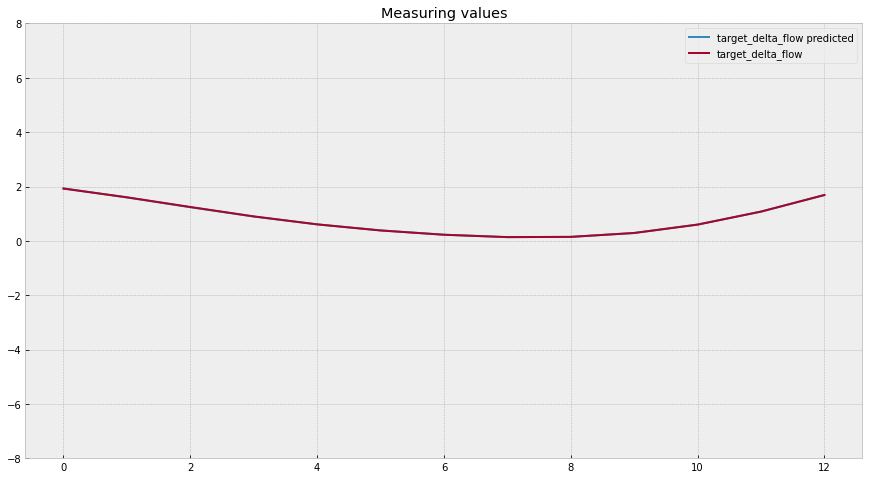

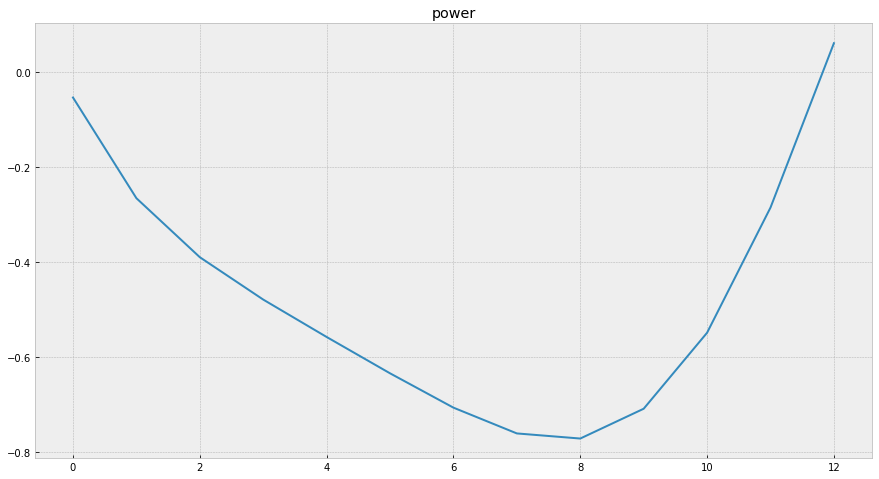

In [9]:
#Plot merged data np
def plot_data(inp_np, ll=0, ul=1, plot_together=True):
    ll = round(len(inp_np) * ll) 
    ul = round(len(inp_np) * ul) 
    if plot_together:
        with plt.style.context('bmh'):    
            plt.figure(figsize=(15, 8))
            plt.plot(inp_np[ll:ul,:]);
            plt.legend([columns_analyze[k] for k in range(inp_np.shape[1])])
    else:
        for k in range(inp_np.shape[1]):
            with plt.style.context('bmh'):    
                plt.figure(figsize=(15, 8))
                col_name = columns_analyze[k]
                plt.title("Measuring %s"%col_name)
                plt.plot(inp_np[ll:ul,k]);



plot_predicted(X_train,y_train,model,range_low = 0,range_high=1, range_up = 8, range_down = -8, extra_plot_list=['power'])